In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)
import collections

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from typing import Callable, Iterable, Optional

## 1. Функции для расчета энтропии и прироста информации (5 баллов)

Пример для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [2]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

Дальше пусть шарики разбиваются на 2 группы

In [3]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

**Реализуйте функцию для расчета энтропии Шеннона.**

In [4]:
prob = lambda x,y : x/y
def entropy(a_list: Iterable) -> float:
    '''
    Function that return the shannon's entropy of an array
    '''
    val_counts = collections.Counter([x for x in a_list])
    return -sum([prob(count, len(a_list)) * np.log2(prob(count, len(a_list))) for count in val_counts.values()])

Проверка

In [5]:
print(entropy(balls)) # 9 синих и 11 желтых
print(entropy(balls_left)) # 8 синих и 5 желтых
print(entropy(balls_right)) # 1 синий и 6 желтых
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


Сверим с реализацией в Scipy

In [6]:
from scipy.stats import entropy as scipy_entropy

def shannon_entropy_scipy(a_list: Iterable):
    val_counts = collections.Counter([x for x in a_list])
    return scipy_entropy([prob(count, len(a_list)) 
            for count in val_counts.values()], base=2)

In [7]:
assert entropy(balls) - shannon_entropy_scipy(balls) < 1e-9
assert entropy(balls_left) - shannon_entropy_scipy(balls_left) < 1e-9 
assert entropy(balls_right) - shannon_entropy_scipy(balls_right) < 1e-9
assert entropy([1,2,3,4,5,6]) - shannon_entropy_scipy([1,2,3,4,5,6]) < 1e-9

Чему равна энтропия состояния, заданного списком `balls_left`?

0.961

Чему равна энтропия игральной кости с несмещенным центром тяжести?

2.585

In [8]:
# расчет прироста информации

def information_gain(root: Iterable, left: Iterable, right: Iterable) -> float:
    ''' root - изначальный набор данных, left и right два разбиения изначального набора'''
    
    return entropy(root) - len(left) / \
        len(root) * entropy(left) - len(right) / len(root) * entropy(right)

Каков прирост информации при разделении выборки на `balls_left` и `balls_right`?

In [9]:
print(information_gain(balls, balls_left, balls_right))

0.16088518841412436


In [10]:
def best_feature_to_split(X, y, verbose=0):
    ''' Выводит прирост информации при разбиении по каждому признаку'''
    res = []
    for col in X.columns:
        if verbose: 
            print(col)
        for val in X[col].unique():
            left = [y[j] for j in range(len(y)) if X[col][j] <= val]
            right = [y[j] for j in range(len(y)) if X[col][j] > val]
            res.append(information_gain(y, left, right))
    return res

In [11]:
df_balls = pd.DataFrame(range(len(balls)), columns=["Feature 1"])

In [12]:
print(best_feature_to_split(df_balls, balls, verbose=1))

Feature 1
[0.05993070646691556, 0.12510356566040215, 0.1966071793918801, 0.27594386796016235, 0.36529389753193287, 0.4680577739061723, 0.5901760274466118, 0.7444843438056281, 0.9927744539878083, 0.7582766571931676, 0.6165533143863353, 0.5060075793123286, 0.4139548878451389, 0.33457428291836655, 0.2645615081468069, 0.20181492735701023, 0.14489728957406034, 0.09277445398780826, 0.044673614309123755, 0.0]


## 2. Деревья решений на наборе данных Adult (10 баллов)

**Описание набора:**

https://archive.ics.uci.edu/ml/datasets/adult (для ознакомления, а сами данные adult_train, adult_test располагаются в папке datasets на нашем GitHub):

Классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более 50 000 \$ в год.

Описание признаков: 

**Age** – возраст, количественный признак  
**Workclass** – тип работодателя, количественный признак  
**fnlwgt** – итоговый вес обьекта, количественный признак    
**Education** – уровень образования, качественный признак  
**Education_Num** – количество лет обучения, количественный признак  
**Martial_Status** – семейное положение, категориальный признак  
**Occupation** – профессия, категориальный признак  
**Relationship** – тип семейных отношений, категориальный признак    
**Race** – раса, категориальный признак  
**Sex** – пол, качественный признак  
**Capital_Gain** – прирост капитала, количественный признак  
**Capital_Loss** – потери капитала, количественный признак  
**Hours_per_week** – количество часов работы в неделю, количественный признак  
**Country** – страна, категориальный признак  
   
Целевая переменная: **Target** – уровень заработка, категориальный (бинарный) признак  

**Считываем обучающую и тестовую выборки.**

In [21]:
# если в Jupyter Notebook:
import os
# data_train = pd.read_csv('../../data/adult_train.csv', sep=';') 
DATA_PATH = "./data/"
TRAIN_DATA_PATH = os.path.join(DATA_PATH, "adult_train.csv")
TEST_DATA_PATH = os.path.join(DATA_PATH, "adult_test.csv")
data_train = pd.read_csv(TRAIN_DATA_PATH, sep=";")
data_train.shape

(32561, 15)

In [22]:
data_train.tail()

Age      Workclass  fnlwgt    Education  Education_Num  \
32556   27        Private  257302   Assoc-acdm             12   
32557   40        Private  154374      HS-grad              9   
32558   58        Private  151910      HS-grad              9   
32559   22        Private  201490      HS-grad              9   
32560   52   Self-emp-inc  287927      HS-grad              9   

            Martial_Status          Occupation Relationship    Race      Sex  \
32556   Married-civ-spouse        Tech-support         Wife   White   Female   
32557   Married-civ-spouse   Machine-op-inspct      Husband   White     Male   
32558              Widowed        Adm-clerical    Unmarried   White   Female   
32559        Never-married        Adm-clerical    Own-child   White     Male   
32560   Married-civ-spouse     Exec-managerial         Wife   White   Female   

       Capital_Gain  Capital_Loss  Hours_per_week         Country  Target  
32556             0             0              38   United-States   <=50K  
32557             0             0              40   United-States    >50K  
32558             0             0              40   United-States   <=50K  
32559             0             0              20   United-States   <=50K  
32560         15024             0              40   United-States    >50K

In [23]:
# data_test = pd.read_csv('../../data/adult_test.csv', sep=';') 
data_test = pd.read_csv(TEST_DATA_PATH, sep=";")

In [24]:
data_test.tail()

Age      Workclass    fnlwgt   Education  Education_Num  \
16277  39        Private  215419.0   Bachelors           13.0   
16278  64            NaN  321403.0     HS-grad            9.0   
16279  38        Private  374983.0   Bachelors           13.0   
16280  44        Private   83891.0   Bachelors           13.0   
16281  35   Self-emp-inc  182148.0   Bachelors           13.0   

            Martial_Status        Occupation     Relationship  \
16277             Divorced    Prof-specialty    Not-in-family   
16278              Widowed               NaN   Other-relative   
16279   Married-civ-spouse    Prof-specialty          Husband   
16280             Divorced      Adm-clerical        Own-child   
16281   Married-civ-spouse   Exec-managerial          Husband   

                      Race      Sex  Capital_Gain  Capital_Loss  \
16277                White   Female           0.0           0.0   
16278                Black     Male           0.0           0.0   
16279                White     Male           0.0           0.0   
16280   Asian-Pac-Islander     Male        5455.0           0.0   
16281                White     Male           0.0           0.0   

       Hours_per_week         Country   Target  
16277            36.0   United-States   <=50K.  
16278            40.0   United-States   <=50K.  
16279            50.0   United-States   <=50K.  
16280            40.0   United-States   <=50K.  
16281            60.0   United-States    >50K.

In [25]:
data_test.head()

Age   Workclass    fnlwgt      Education  Education_Num  \
0  |1x3 Cross validator         NaN       NaN            NaN            NaN   
1                    25     Private  226802.0           11th            7.0   
2                    38     Private   89814.0        HS-grad            9.0   
3                    28   Local-gov  336951.0     Assoc-acdm           12.0   
4                    44     Private  160323.0   Some-college           10.0   

        Martial_Status          Occupation Relationship    Race    Sex  \
0                  NaN                 NaN          NaN     NaN    NaN   
1        Never-married   Machine-op-inspct    Own-child   Black   Male   
2   Married-civ-spouse     Farming-fishing      Husband   White   Male   
3   Married-civ-spouse     Protective-serv      Husband   White   Male   
4   Married-civ-spouse   Machine-op-inspct      Husband   Black   Male   

   Capital_Gain  Capital_Loss  Hours_per_week         Country   Target  
0           NaN           NaN             NaN             NaN      NaN  
1           0.0           0.0            40.0   United-States   <=50K.  
2           0.0           0.0            50.0   United-States   <=50K.  
3           0.0           0.0            40.0   United-States    >50K.  
4        7688.0           0.0            40.0   United-States    >50K.

Удалим первую строку

In [26]:
data_test.drop(index=data_test.index[0], 
        axis=0, 
        inplace=True)
data_test.head()

Age   Workclass    fnlwgt      Education  Education_Num  \
1  25     Private  226802.0           11th            7.0   
2  38     Private   89814.0        HS-grad            9.0   
3  28   Local-gov  336951.0     Assoc-acdm           12.0   
4  44     Private  160323.0   Some-college           10.0   
5  18         NaN  103497.0   Some-college           10.0   

        Martial_Status          Occupation Relationship    Race      Sex  \
1        Never-married   Machine-op-inspct    Own-child   Black     Male   
2   Married-civ-spouse     Farming-fishing      Husband   White     Male   
3   Married-civ-spouse     Protective-serv      Husband   White     Male   
4   Married-civ-spouse   Machine-op-inspct      Husband   Black     Male   
5        Never-married                 NaN    Own-child   White   Female   

   Capital_Gain  Capital_Loss  Hours_per_week         Country   Target  
1           0.0           0.0            40.0   United-States   <=50K.  
2           0.0           0.0            50.0   United-States   <=50K.  
3           0.0           0.0            40.0   United-States    >50K.  
4        7688.0           0.0            40.0   United-States    >50K.  
5           0.0           0.0            30.0   United-States   <=50K.

In [27]:
# # если в Google Colab: 

# from google.colab import drive
# drive.mount('/content/drive')

# data_train = pd.read_csv("/content/drive/MyDrive/adult_train.csv", sep=';') 
# data_train.tail()

# data_test = pd.read_csv("/content/drive/MyDrive/adult_test.csv", sep=';') 
# data_test.tail()

In [28]:
# необходимо убрать строки с неправильными метками в тестовой выборке
data_test = data_test[(data_test['Target'] == ' >50K.') 
                      | (data_test['Target']==' <=50K.')]

# перекодируем target в числовое поле
data_train.loc[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.loc[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.loc[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target'] == ' >50K.', 'Target'] = 1

**Первичный анализ данных.**

In [29]:
data_test.describe(include='all').T

count unique                  top     freq           mean  \
Age               16281     73                   35      461            NaN   
Workclass         15318      8              Private    11210            NaN   
fnlwgt          16281.0    NaN                  NaN      NaN  189435.677784   
Education         16281     16              HS-grad     5283            NaN   
Education_Num   16281.0    NaN                  NaN      NaN      10.072907   
Martial_Status    16281      7   Married-civ-spouse     7403            NaN   
Occupation        15315     14       Prof-specialty     2032            NaN   
Relationship      16281      6              Husband     6523            NaN   
Race              16281      5                White    13946            NaN   
Sex               16281      2                 Male    10860            NaN   
Capital_Gain    16281.0    NaN                  NaN      NaN    1081.905104   
Capital_Loss    16281.0    NaN                  NaN      NaN      87.899269   
Hours_per_week  16281.0    NaN                  NaN      NaN      40.392236   
Country           16007     40        United-States    14662            NaN   
Target          16281.0    2.0                  0.0  12435.0            NaN   

                          std      min       25%       50%       75%  \
Age                       NaN      NaN       NaN       NaN       NaN   
Workclass                 NaN      NaN       NaN       NaN       NaN   
fnlwgt          105714.907671  13492.0  116736.0  177831.0  238384.0   
Education                 NaN      NaN       NaN       NaN       NaN   
Education_Num        2.567545      1.0       9.0      10.0      12.0   
Martial_Status            NaN      NaN       NaN       NaN       NaN   
Occupation                NaN      NaN       NaN       NaN       NaN   
Relationship              NaN      NaN       NaN       NaN       NaN   
Race                      NaN      NaN       NaN       NaN       NaN   
Sex                       NaN      NaN       NaN       NaN       NaN   
Capital_Gain      7583.935968      0.0       0.0       0.0       0.0   
Capital_Loss       403.105286      0.0       0.0       0.0       0.0   
Hours_per_week      12.479332      1.0      40.0      40.0      45.0   
Country                   NaN      NaN       NaN       NaN       NaN   
Target                    NaN      NaN       NaN       NaN       NaN   

                      max  
Age                   NaN  
Workclass             NaN  
fnlwgt          1490400.0  
Education             NaN  
Education_Num        16.0  
Martial_Status        NaN  
Occupation            NaN  
Relationship          NaN  
Race                  NaN  
Sex                   NaN  
Capital_Gain      99999.0  
Capital_Loss       3770.0  
Hours_per_week       99.0  
Country               NaN  
Target                NaN

In [30]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

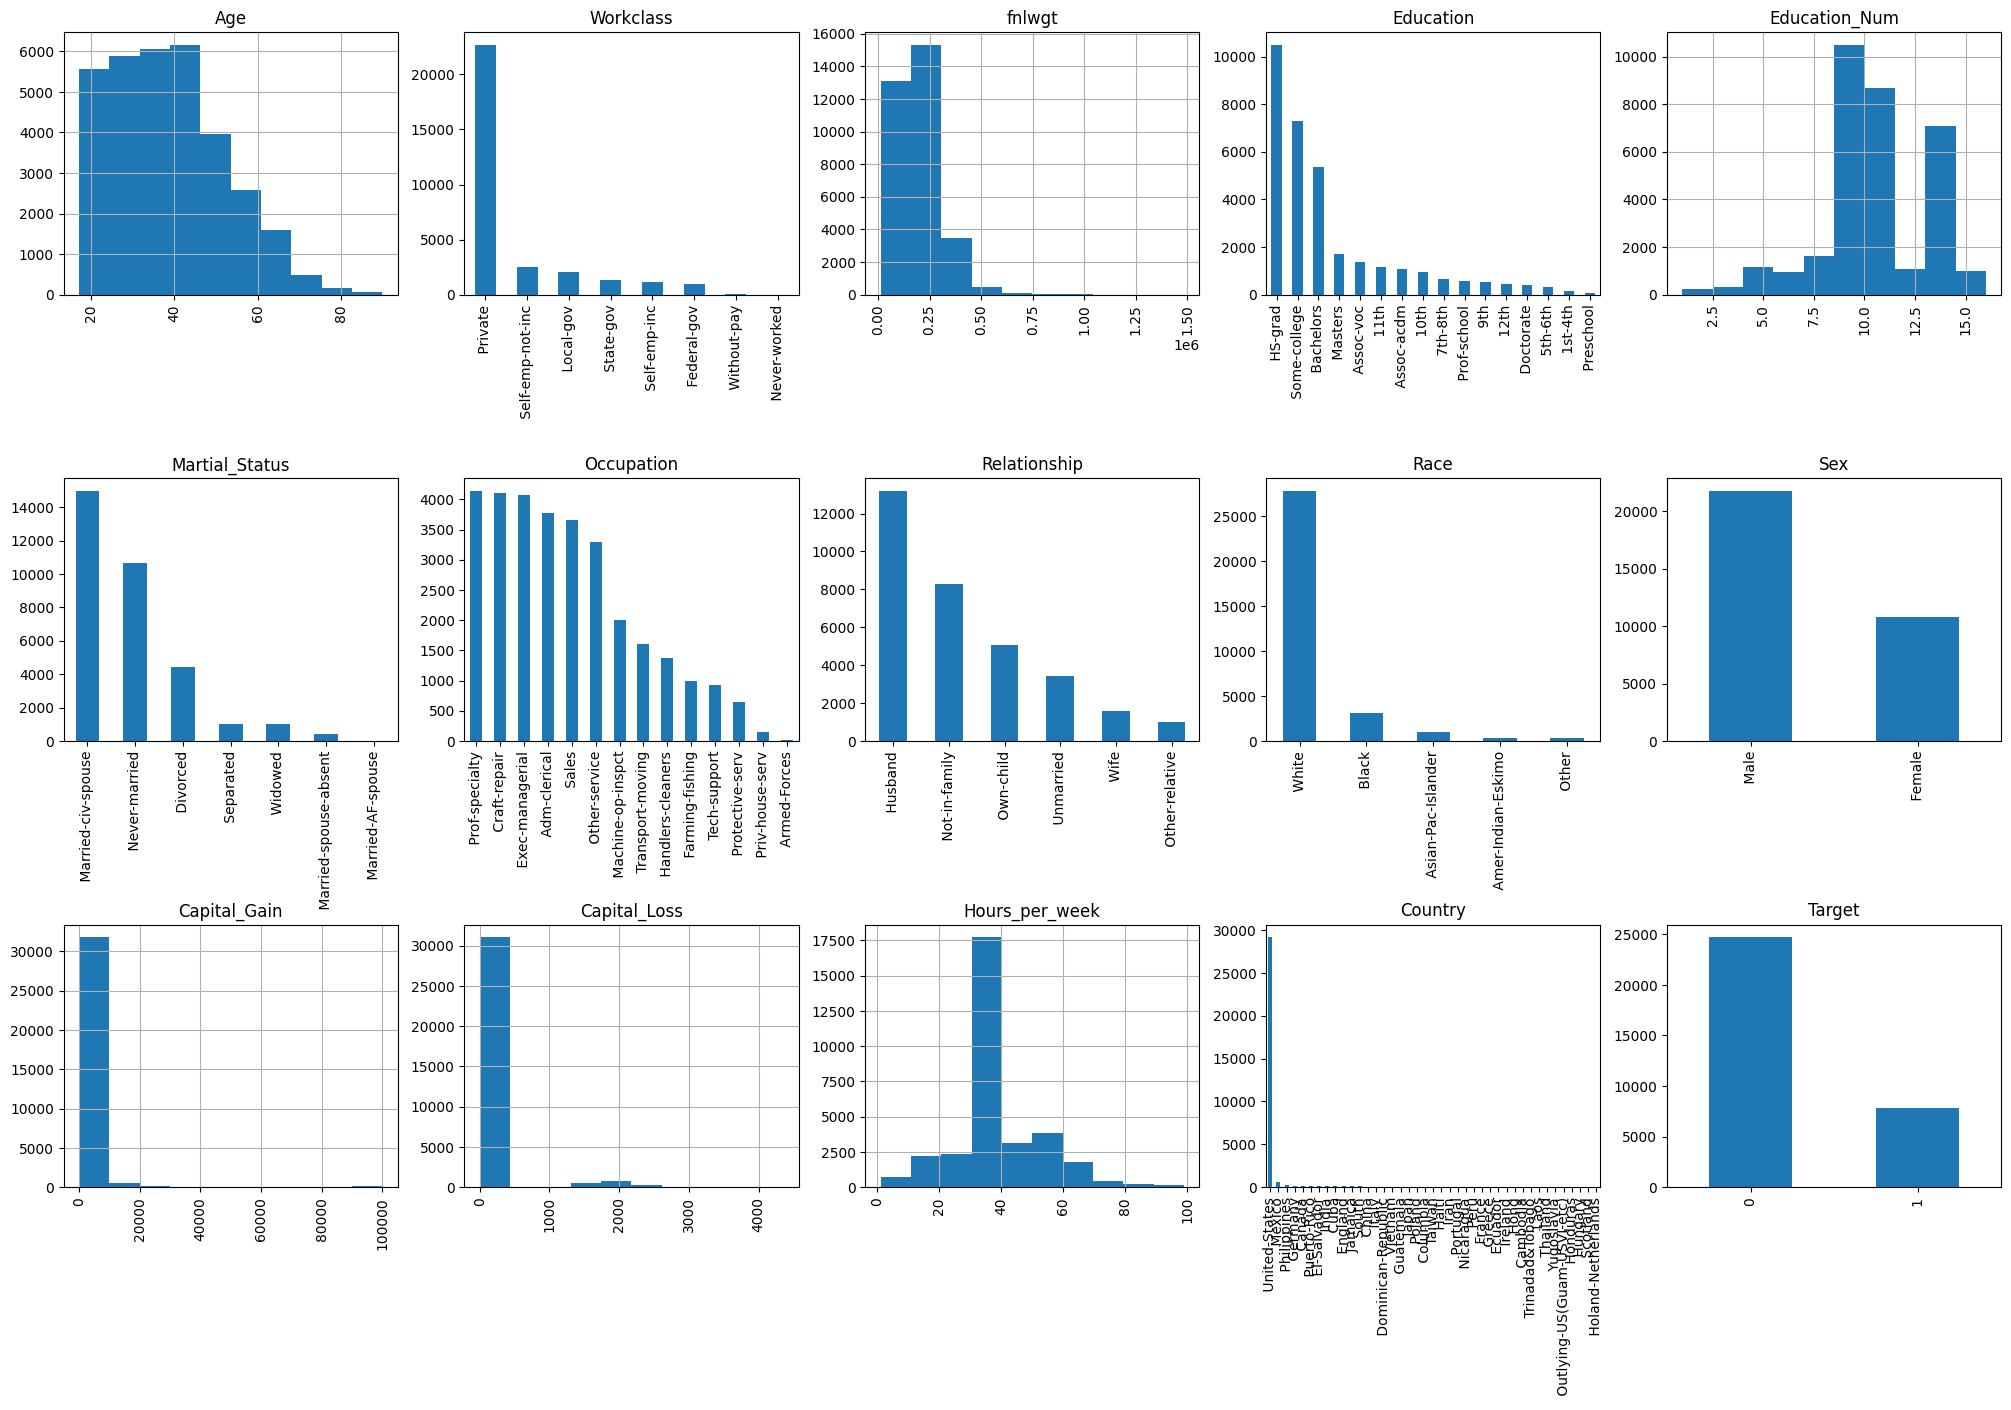

In [31]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(np.ceil(float(data_train.shape[1]) / cols))
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object_:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

**Проверяем типы данных**

In [32]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [33]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

Выяснилось, что в тесте возраст отнесен к типу object, необходимо это исправить.

In [34]:
data_test['Age'] = data_test['Age'].astype(int)

Также приведем показатели типа float в int для соответствия train и test выборок.

In [35]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

**Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением**

In [36]:
# выделим в выборках категориальные и числовые поля

categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

categorical_columns_test: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
categorical_columns_train: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Target']
numerical_columns_test: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']
numerical_columns_train: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


In [37]:
data_train.isna().sum()

Age                  0
Workclass         1836
fnlwgt               0
Education            0
Education_Num        0
Martial_Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_Gain         0
Capital_Loss         0
Hours_per_week       0
Country            583
Target               0
dtype: int64

In [38]:
# заполним пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode()[0])
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode()[0])
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())    

In [39]:
data_train.isna().sum()

Age               0
Workclass         0
fnlwgt            0
Education         0
Education_Num     0
Martial_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_per_week    0
Country           0
Target            0
dtype: int64

**Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода `pandas get_dummies`.**

In [40]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [41]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [42]:
data_test.describe(include='all').T

count           mean            std      min  \
Age                       16281.0      38.767459      13.849187     17.0   
fnlwgt                    16281.0  189435.677784  105714.907671  13492.0   
Education_Num             16281.0      10.072907       2.567545      1.0   
Capital_Gain              16281.0    1081.905104    7583.935968      0.0   
Capital_Loss              16281.0      87.899269     403.105286      0.0   
...                           ...            ...            ...      ...   
Country_ Thailand         16281.0       0.000737       0.027140      0.0   
Country_ Trinadad&Tobago  16281.0       0.000491       0.022162      0.0   
Country_ United-States    16281.0       0.917388       0.275303      0.0   
Country_ Vietnam          16281.0       0.001167       0.034143      0.0   
Country_ Yugoslavia       16281.0       0.000430       0.020731      0.0   

                               25%       50%       75%        max  
Age                           28.0      37.0      48.0       90.0  
fnlwgt                    116736.0  177831.0  238384.0  1490400.0  
Education_Num                  9.0      10.0      12.0       16.0  
Capital_Gain                   0.0       0.0       0.0    99999.0  
Capital_Loss                   0.0       0.0       0.0     3770.0  
...                            ...       ...       ...        ...  
Country_ Thailand              0.0       0.0       0.0        1.0  
Country_ Trinadad&Tobago       0.0       0.0       0.0        1.0  
Country_ United-States         1.0       1.0       1.0        1.0  
Country_ Vietnam               0.0       0.0       0.0        1.0  
Country_ Yugoslavia            0.0       0.0       0.0        1.0  

[105 rows x 8 columns]

In [43]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [44]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

**В тестовой выборке не оказалось Голландии. Заведем необходимый признак из нулей.**

In [45]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [46]:
set(data_train.columns) - set(data_test.columns)

set()

In [47]:
data_train.head(2)

Age  fnlwgt  Education_Num  Capital_Gain  Capital_Loss  Hours_per_week  \
0   39   77516             13          2174             0              40   
1   50   83311             13             0             0              13   

   Target  Workclass_ Federal-gov  Workclass_ Local-gov  \
0       0                       0                     0   
1       0                       0                     0   

   Workclass_ Never-worked  ...  Country_ Portugal  Country_ Puerto-Rico  \
0                        0  ...                  0                     0   
1                        0  ...                  0                     0   

   Country_ Scotland  Country_ South  Country_ Taiwan  Country_ Thailand  \
0                  0               0                0                  0   
1                  0               0                0                  0   

   Country_ Trinadad&Tobago  Country_ United-States  Country_ Vietnam  \
0                         0                       1                 0   
1                         0                       1                 0   

   Country_ Yugoslavia  
0                    0  
1                    0  

[2 rows x 106 columns]

In [48]:
data_test.head(2)

Age  fnlwgt  Education_Num  Capital_Gain  Capital_Loss  Hours_per_week  \
1   25  226802              7             0             0              40   
2   38   89814              9             0             0              50   

   Target  Workclass_ Federal-gov  Workclass_ Local-gov  \
1       0                       0                     0   
2       0                       0                     0   

   Workclass_ Never-worked  ...  Country_ Puerto-Rico  Country_ Scotland  \
1                        0  ...                     0                  0   
2                        0  ...                     0                  0   

   Country_ South  Country_ Taiwan  Country_ Thailand  \
1               0                0                  0   
2               0                0                  0   

   Country_ Trinadad&Tobago  Country_ United-States  Country_ Vietnam  \
1                         0                       1                 0   
2                         0                       1                 0   

   Country_ Yugoslavia  Country_ Holand-Netherlands  
1                    0                          0.0  
2                    0                          0.0  

[2 rows x 106 columns]

In [49]:
data_train = data_train.sort_index(axis=1)
data_test = data_test.sort_index(axis=1)

In [50]:
X_train=data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

## 2.1. Дерево решений без настройки параметров (5 баллов)

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 3 и получите качество на тесте. Используйте параметр `random_state` = 17 для воспроизводимости результатов.**

In [51]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)# Ваш код здесь
tree.fit(X_train, y_train) # Ваш код здесь

DecisionTreeClassifier(max_depth=3, random_state=17)

**Сделайте с помощью полученной модели прогноз для тестовой выборки.**

In [52]:
tree_predictions = tree.predict(X_test) # Ваш код здесь

In [53]:
accuracy_score(y_test, tree_predictions) # Ваш код здесь

0.8447884036607088

Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 3 и random_state = 17?

0.845

## 2.2. Дерево решений с настройкой параметров (5 баллов)

**Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`, опять `random_state` = 17 ). Максимальную глубину настройте на кросс-валидации с помощью `GridSearchCV`.**

In [54]:
tree_params = {'max_depth': range(2,11)}

clf = DecisionTreeClassifier(random_state=17)
locally_best_tree = GridSearchCV(clf, tree_params) # Ваш код здесь                      

locally_best_tree.fit(X_train, y_train) # Ваш код здесь

GridSearchCV(estimator=DecisionTreeClassifier(random_state=17),
             param_grid={'max_depth': range(2, 11)})

In [55]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8563006334712921


**Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение `max_depth` в моем случае) и   оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.**

In [56]:
accuracy_score(locally_best_tree.best_estimator_.predict(X_test), y_test)

0.8576254529820035

In [57]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17) # Ваш код здесь
tuned_tree.fit(X_train, y_train) # Ваш код здесь
tuned_tree_predictions = tuned_tree.predict(X_test) # Ваш код здесь
accuracy_score(y_test, tuned_tree_predictions) # Ваш код здесь

0.8576254529820035

Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 9 и random_state = 17?

In [58]:
0.86

0.86

# 3. Логистическая регрессия в задаче кредитного скоринга (15 баллов)



#### Данные представлены следующим образом (credit_scoring_sample из наших datasets на GitHub):

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

In [59]:
%matplotlib inline

import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [60]:
TRAIN_DATA_PATH = os.path.join(DATA_PATH, "credit_scoring_sample.csv")

In [61]:
## Считываем данные 

data = pd.read_csv(TRAIN_DATA_PATH, sep=";") # прописать путь в ависимости от того, где выполняете работу
data.head()

SeriousDlqin2yrs  age  NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  \
0                 0   64                                     0     0.249908   
1                 0   58                                     0  3870.000000   
2                 0   41                                     0     0.456127   
3                 0   43                                     0     0.000190   
4                 1   49                                     0     0.271820   

   NumberOfTimes90DaysLate  NumberOfTime60-89DaysPastDueNotWorse  \
0                        0                                     0   
1                        0                                     0   
2                        0                                     0   
3                        0                                     0   
4                        0                                     0   

   MonthlyIncome  NumberOfDependents  
0         8158.0                 0.0  
1            NaN                 0.0  
2         6666.0                 0.0  
3        10500.0                 2.0  
4          400.0                 0.0

In [62]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

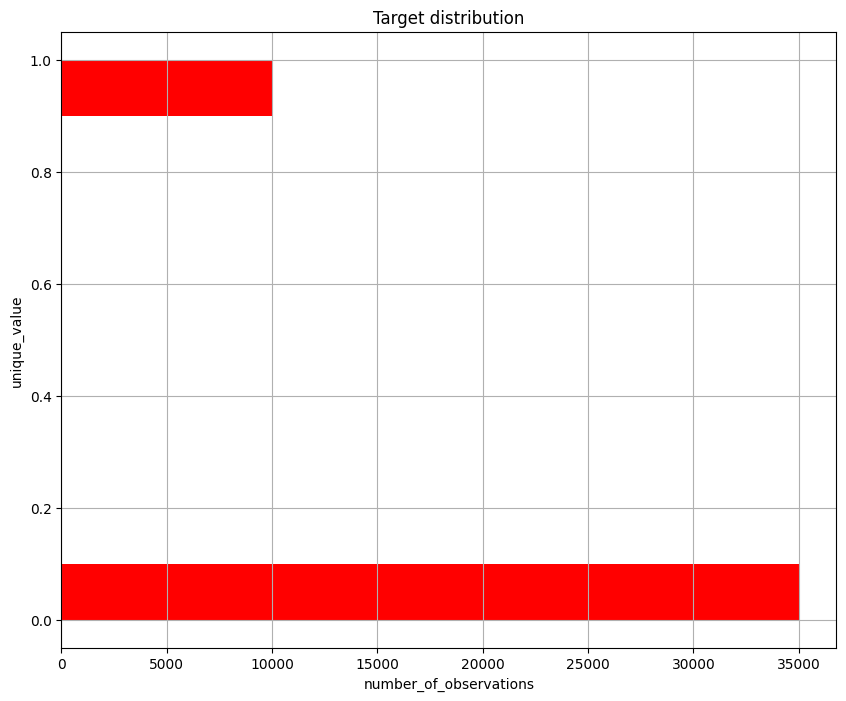

In [63]:
## Посмотрим на распределение классов в зависимой переменной

ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [64]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [65]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = data.fillna(data.mean())

In [66]:
## Разделяем таргет и признаки
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0 до 1. Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler


# Используем модуль LogisticRegression для построения логистической регрессии.
# Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
# Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight="balanced")
pipe = make_pipeline(StandardScaler(), lr)
# Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
# Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны,
# и будет хорошо предсказывать значения таргета, с другой.
# Остальные параметры оставляем по умолчанию.
parameters = {"logisticregression__C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

# Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть
# значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [68]:
# Можно ли считать лучшую модель устойчивой? 
# (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) 
# Cохраните точность лучшей модели, она вам приходится для следующих заданий
grid = GridSearchCV(pipe, parameters, scoring='roc_auc', cv=skf)
grid.fit(X, y)
print("Лучшие параметры: ", grid.best_params_)
print("Лучший скор через кросс-валидацию: ", grid.best_score_)
std_cv = grid.cv_results_['std_test_score'][grid.best_index_]
print("STD лучшей модели: %.3f"%std_cv)
if std_cv < 0.5:
    print("Модель устойчива")
else:
    print("Модель не устойчива")
### Ваш код должен быть здесь ###

Лучшие параметры:  {'logisticregression__C': 10}
Лучший скор через кросс-валидацию:  0.7880196357848961
STD лучшей модели: 0.003
Модель устойчива


## 3.1 Определение влияния признаков (5 баллов) 

Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [69]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

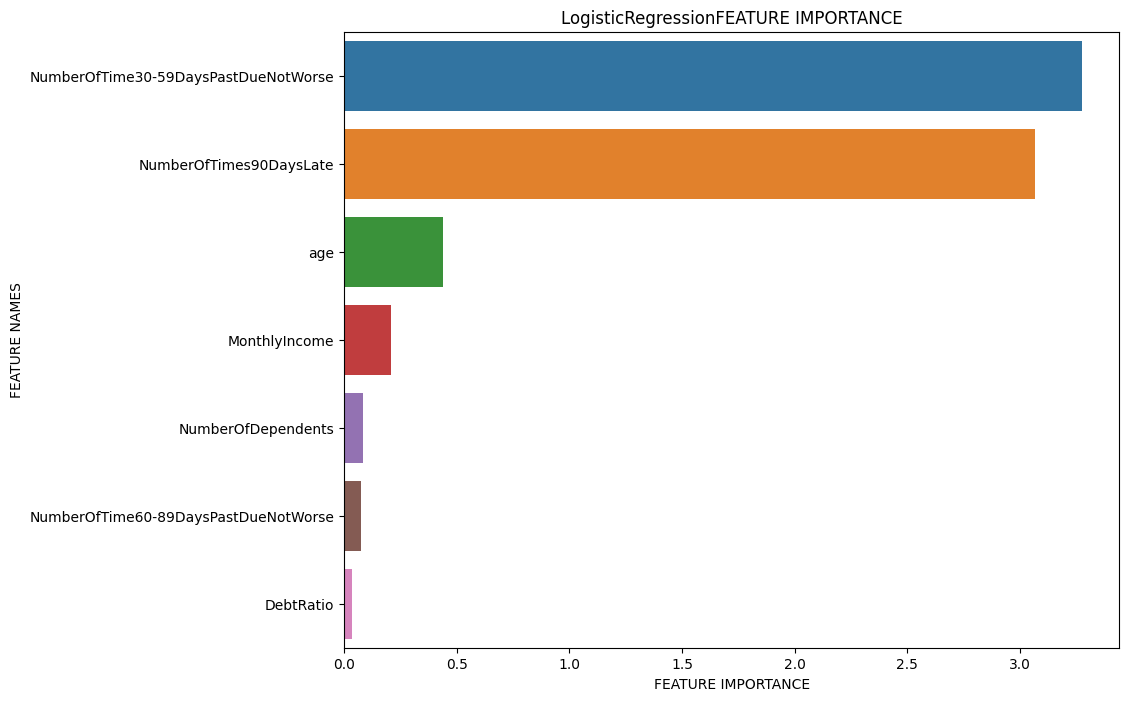

In [70]:
importances = abs(grid.best_estimator_['logisticregression'].coef_[0])
plot_feature_importance(importances, independent_columns_names, model_type="LogisticRegression")

In [71]:
from scipy.special import softmax
# Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией softmax)
print("Доля влияния признака DebtRatio: %.3f"%(softmax(importances)[independent_columns_names.index("DebtRatio")] * 100))
### Ваш код должен быть здесь ###

Доля влияния признака DebtRatio: 1.920


# 4. Случайный лес (5 баллов) 

In [72]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)
pipe = make_pipeline(StandardScaler(), rf)

## Будем искать лучшие параметры среди следующего набора
parameters = {
    "randomforestclassifier__max_features": [1, 2, 4],
    "randomforestclassifier__min_samples_leaf": [3, 5, 7, 9],
    "randomforestclassifier__max_depth": [5, 10, 15],
}

## Делаем опять же k-fold валидацию. 

In [73]:
# Насколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?
grid = GridSearchCV(pipe, parameters, scoring='roc_auc', cv=skf, verbose=1)
grid.fit(X, y)

print("Лучшие параметры: ", grid.best_params_)
print("Лучший скор через кросс-валидацию: ", grid.best_score_)
std_cv = grid.cv_results_['std_test_score'][grid.best_index_]
print("STD лучшей модели: %.3f"%std_cv)
if std_cv < 0.5:
    print("Модель устойчива")
else:
    print("Модель не устойчива")
### Ваш код должен быть здесь ###
### Ваш код должен быть здесь ###

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 2, 'randomforestclassifier__min_samples_leaf': 7}
Лучший скор через кросс-валидацию:  0.8352786636278842
STD лучшей модели: 0.004
Модель устойчива


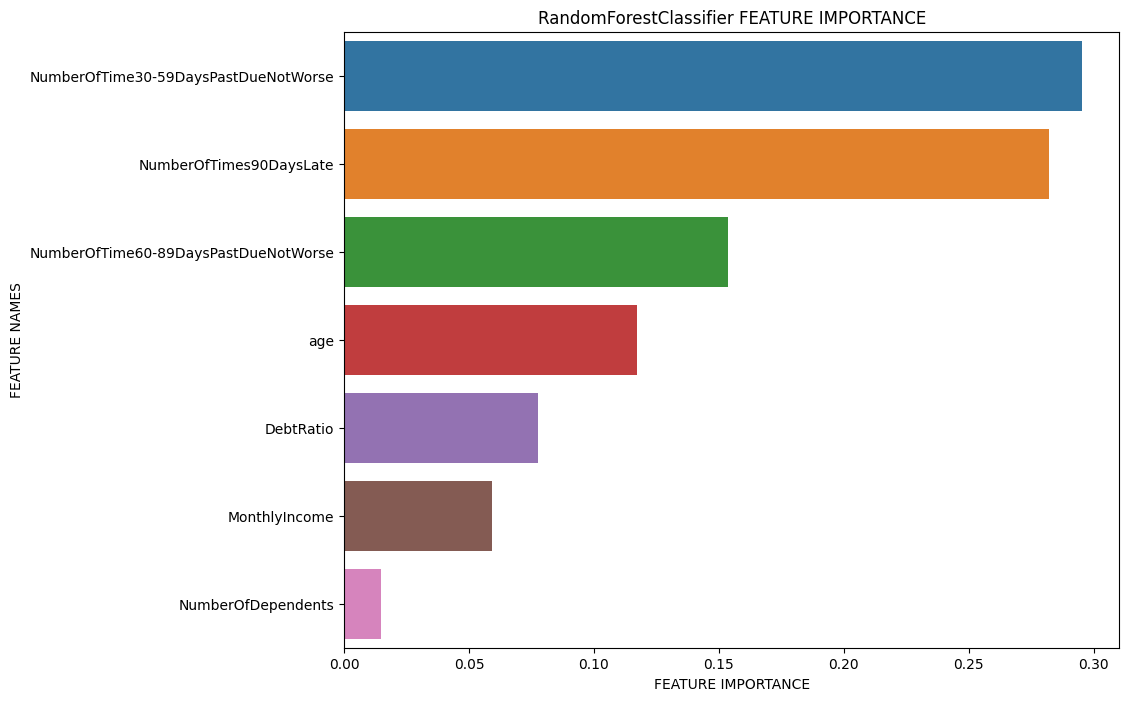

In [74]:
# Какой признак имеет наименьшее влияние?
plot_feature_importance(grid.best_estimator_['randomforestclassifier'].feature_importances_, independent_columns_names, model_type="RandomForestClassifier ")
### Ваш код должен быть здесь ###